In [37]:
# %matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform

cap = cv2.VideoCapture("DrivingVideo.mp4")
print("Number of frames in video: ", cap.get(cv2.CAP_PROP_FRAME_COUNT))
W, H = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Width, Height: ", W, H)

Number of frames in video:  813.0
Width, Height:  1280 720


In [38]:
frame1 = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)

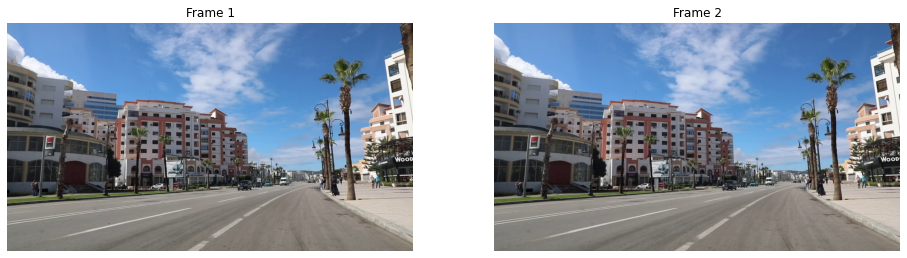

In [39]:
def showImages(frame1, frame2):
    f, ax = plt.subplots(1,2,figsize=[16,16])
    ax[0].imshow(frame1), ax[1].imshow(frame2)
    ax[0].axis('off'), ax[1].axis('off'), ax[0].title.set_text('Frame 1'), ax[1].title.set_text('Frame 2')

showImages(frame1, frame2)

Ok, the last time around we got stuck because:

* we were not detecting enough features
* the feature matches that we found were not great

Shown below is where we were at -- using the ORB detector's default `detect` method did not lead to a lot of good features. 
Additionally, the matches weren't great with large Hamming distances in the "worse" matches (shown in the dump of distances below).

Number of keypoints:  500  and  500


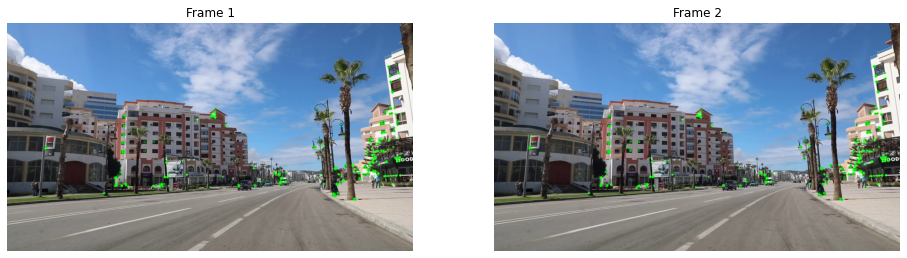

In [53]:
detector = cv2.ORB_create()
kp1, kp2 = detector.detect(frame1, None), detector.detect(frame2, None)

print("Number of keypoints: ", len(kp1)," and ", len(kp2))
# kp1, des1 = detector.compute(frame1, kp1)
# kp2, des2 = detector.compute(frame2, kp2)
# print("Descriptors: ", des1.shape, des2.shape)

frame1_kp = cv2.drawKeypoints(frame1, kp1, None, color=(0,255,0), flags=0)
frame2_kp = cv2.drawKeypoints(frame2, kp2, None, color=(0,255,0), flags=0)
showImages(frame1_kp, frame2_kp)

In [41]:
# show the bad distances here
# print("Number of matches: ", len(matches))
# print([m.distance for m in matches])

### Feature (re-) detection

Another way to get features is to first find nice corners in the frame and then using ORB to figure out descriptors for those specific corners. 
If we can choose nice robust corner features, it will be easier to track them between frames. 
Thankfully, openCV has a function for this - `goodFeaturesToTrack`.

Below, we first find the good features from both frames and convert them the to `KeyPoint` type to work with other openCV functions.
The results are good!
We have 3000 corners with the same corners being detected in both frames, so we can be hopeful for the feature matching step.

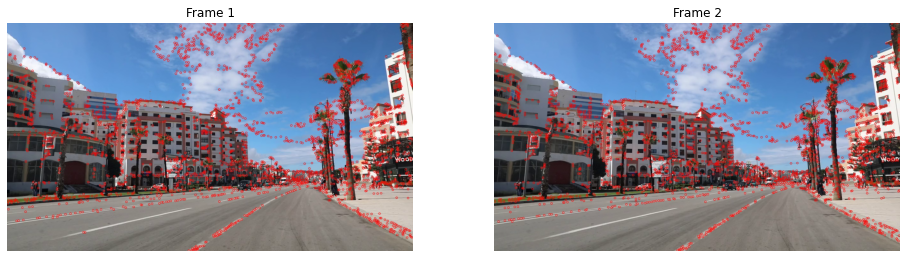

In [42]:
goodFeats1 = cv2.goodFeaturesToTrack(np.mean(frame1, axis = 2, dtype = np.uint8), maxCorners = 3000, qualityLevel = 0.01, minDistance = 3)
goodFeats2 = cv2.goodFeaturesToTrack(np.mean(frame2, axis = 2, dtype = np.uint8), maxCorners = 3000, qualityLevel = 0.01, minDistance = 3)

# convert corners to keypoint type
kp1 = [cv2.KeyPoint(x = f[0][0], y = f[0][1], _size = 20) for f in goodFeats1]
kp2 = [cv2.KeyPoint(x = f[0][0], y = f[0][1], _size = 20) for f in goodFeats2]

frame1_gkp = cv2.drawKeypoints(frame1, kp1, None, color=(255,0,0), flags=0)
frame2_gkp = cv2.drawKeypoints(frame2, kp2, None, color=(255,0,0), flags=0)
showImages(frame1_gkp, frame2_gkp)

### Feature (re-) matching

We can now compute ORB descriptors here (remember that `detector` is an ORB object).
Then, we can use the brute-force matcher to find matches between the two frames, however this time we will use the k-nearest neighbors algorithm.
The default `match()` method of the `BFMatcher` object returns the best match, while the `knnMatch()` method returns the *k* best matches.
This will be useful to do some processing to distinguish good matches from bad ones using [Lowe's ratio test](https://stackoverflow.com/a/60343973/3186279).

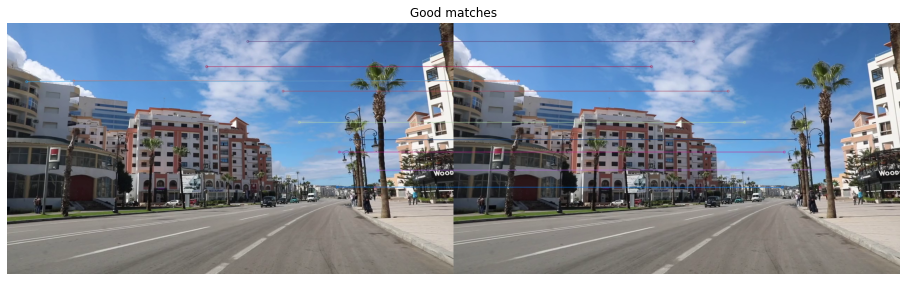

In [43]:
# computing descriptors
kp1, des1 = detector.compute(frame1, kp1)
kp2, des2 = detector.compute(frame2, kp2)
# finding knn matches
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)#, crossCheck = True)
matches = matcher.knnMatch(des1, des2, k = 2)
# applying ratio test
goodMatches = [m for m, n in matches if m.distance < 0.75*n.distance]
# print(goodMatches)

framesMatched = cv2.drawMatchesKnn(frame1, kp1, frame2, kp2, [goodMatches[:10]], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = [16,16]), plt.axis('off'), plt.title("Good matches"), plt.imshow(framesMatched), plt.show();

Displaying the first 10 matches, we can see they look prett good.
Even the bad matches look pretty good!

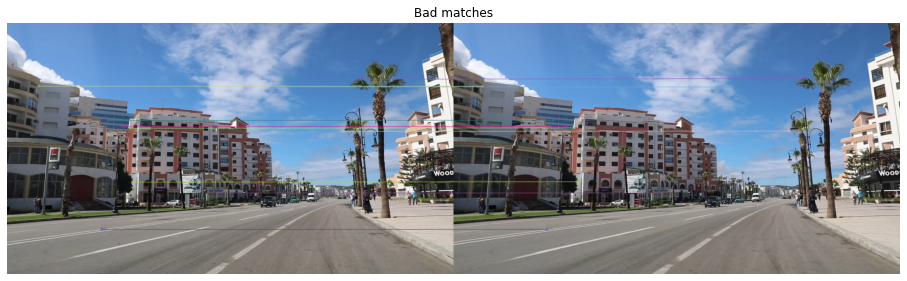

In [44]:
framesBadMatches = cv2.drawMatchesKnn(frame1, kp1, frame2, kp2, [goodMatches[-10:]], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = [16,16]), plt.axis('off'), plt.title("Bad matches"), plt.imshow(framesBadMatches), plt.show();

These matches will still be pretty noise if I were to detect them across all frames in the video, so we need to somehow enforce the perspective projection/projective geometry model on them.
This can be done by using the Fundamental Matrix.

#### Filtering bad matches using the Fundamental Matrix

The **[fundamental matrix](https://en.wikipedia.org/wiki/Fundamental_matrix_(computer_vision))** $F$ is a matrix that maps points in one image to their matches in the other image (I'm not fully sure, but this is typically done in a stereo setting -- however a single moving camera is approximately a stereo camera that is not moving, as long as the frame rate is high enough compared to the camera motion).
Ok, technically it doesn't match points to points, but points to their respective epipolar lines.
Due to the [epipolar constraint](https://en.wikipedia.org/wiki/Epipolar_geometry#Epipolar_constraint_and_triangulation), it is guaranteed that a point in one image plane will have its match in the other (stereo) image frame on a line (called the epipolar line).
This is really cool, because now when we search for a match, we just need to search a line in the image instead of the whole 2-D image.
This constraint restricts our search space by a lot!
Here, we will use this fact in a reverse way.
We already have the matches, thanks to our brute-force matcher -- albeit not all of them are high quality as we saw above.
And we know that the matches must satisfy the epipolar constraint, which is basically saying that they must follow the mapping (or transformation) of the fundamental matrix.
Now, we can tell by looking at each match if it is a good quality match or not, but this constraint gives us a quantitative way of deciding whether a match is a good match or not.
So, the points that don't obey this fundamental matrix transform (or mapping) are bad matches.

There is an algorithm that makes this check for us, called [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus).
We will use this to filter out bad matches.

In [45]:
ransacData = np.array([(kp1[m.queryIdx].pt, kp2[m.trainIdx].pt) for m in goodMatches])
F, inliers = ransac((ransacData[:,0], ransacData[:,1]), FundamentalMatrixTransform, min_samples=8, residual_threshold=1, max_trials=2000)
print("Fundamental Matrix:\n", F.params)

Fundamental Matrix:
 [[-3.21057339e-09 -7.06869109e-06  3.61694483e-03]
 [ 7.06243353e-06  8.61477393e-09 -6.20550265e-03]
 [-3.60822007e-03  6.17921011e-03  8.81471755e-03]]


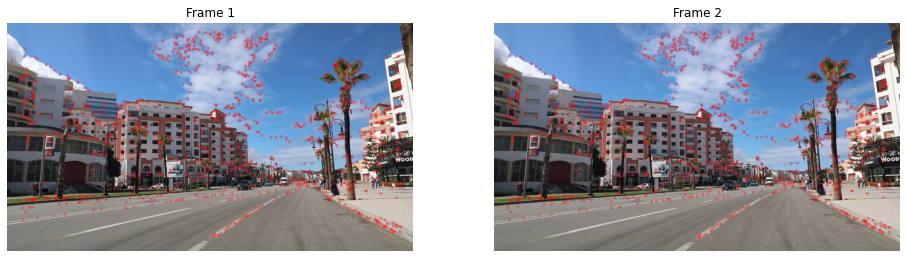

In [46]:
kp1 = [cv2.KeyPoint(x = m[0][0], y = m[0][1], _size = 20) for m in ransacData[inliers]]
kp2 = [cv2.KeyPoint(x = m[1][0], y = m[1][1], _size = 20) for m in ransacData[inliers]]

frame1_gkp = cv2.drawKeypoints(frame1, kp1, None, color=(255,0,0), flags=0)
frame2_gkp = cv2.drawKeypoints(frame2, kp2, None, color=(255,0,0), flags=0)
showImages(frame1_gkp, frame2_gkp)

Above, we can see the keypoints in both frames that best satisfy the epipolar constraint as enforced by the fundamental matrix.

I'm gonna call it here for this post.
This is where we should've been after the first post, but we're exploring here.
In the next post we will talk about estimating the pose of the camera -- it will be math heavy.
See you there.

### References

* [First Principles of Computer Vision](https://www.youtube.com/channel/UCf0WB91t8Ky6AuYcQV0CcLw) YouTube channel
* [twitchslam](https://github.com/geohot/twitchslam) by George Hotz
* [KITTI Odometry with OpenCV Python](https://www.youtube.com/playlist?list=PLrHDCRerOaI9HfgZDbiEncG5dx7S3Nz6X) by Nate Cibik
* Visual Odometry by David Scaramuzza and Friedrich Fraundorfer